In [1]:
# Load NeuroKit and other useful packages
%matplotlib widget


import neurokit2 as nk

import numpy as np 
import pandas as pd
import os

import csv
import itertools
import collections
import pywt

from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [3]:
path = '../Fractal Analysis/mitbih_database//mitbih_database/'
window_size = 1500
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [4]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()



In [5]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)




Data Extraction and Preprocessing


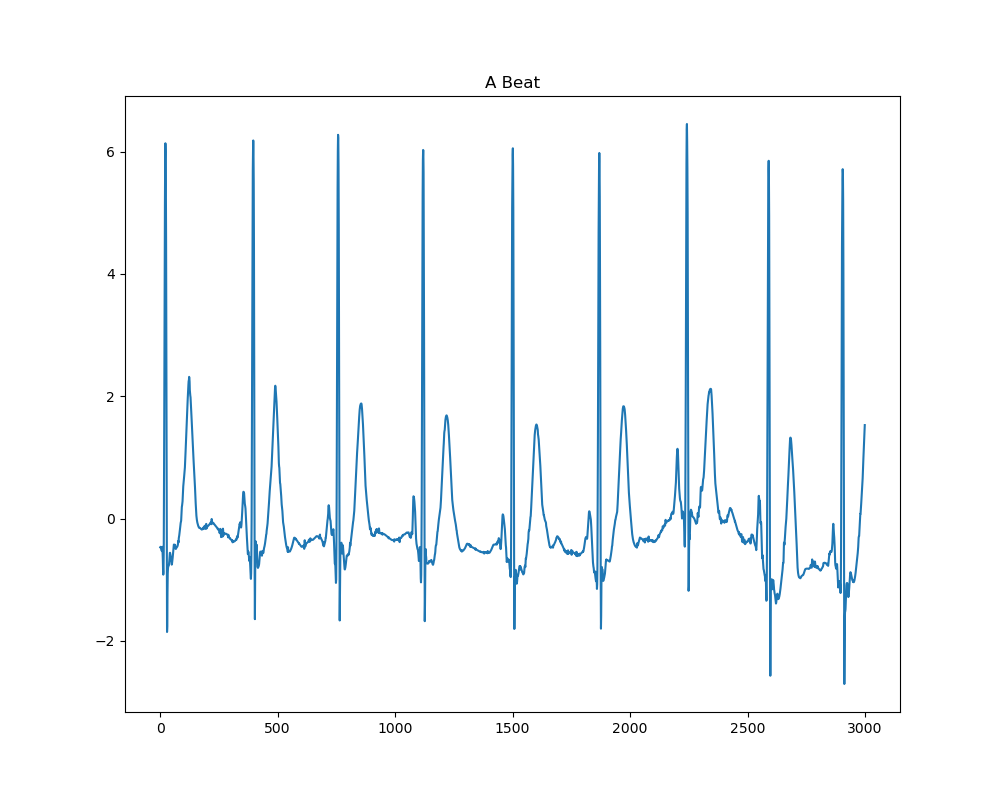

(99598, 3000) (99598,)


In [6]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    #if r == 6:
        # Plot each patient's signal
        #plt.title(records[6] + " Wave")
        #plt.plot(signals[0:700])
        #plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    #if r == 6:
        # Plot each patient's signal
        #plt.title(records[6] + " wave after denoised")
        #plt.plot(signals[0:700])
        #plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    #if r == 6:
        # Plot each patient's signal
        #plt.title(records[6] + " wave after z-score normalization ")
        #plt.plot(signals[0:700])
        #plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 6 and not example_beat_printed: 
                        plt.figure(figsize=(10,8))
                        plt.title("A Beat")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [189]:
signals.shape

(650000,)

2


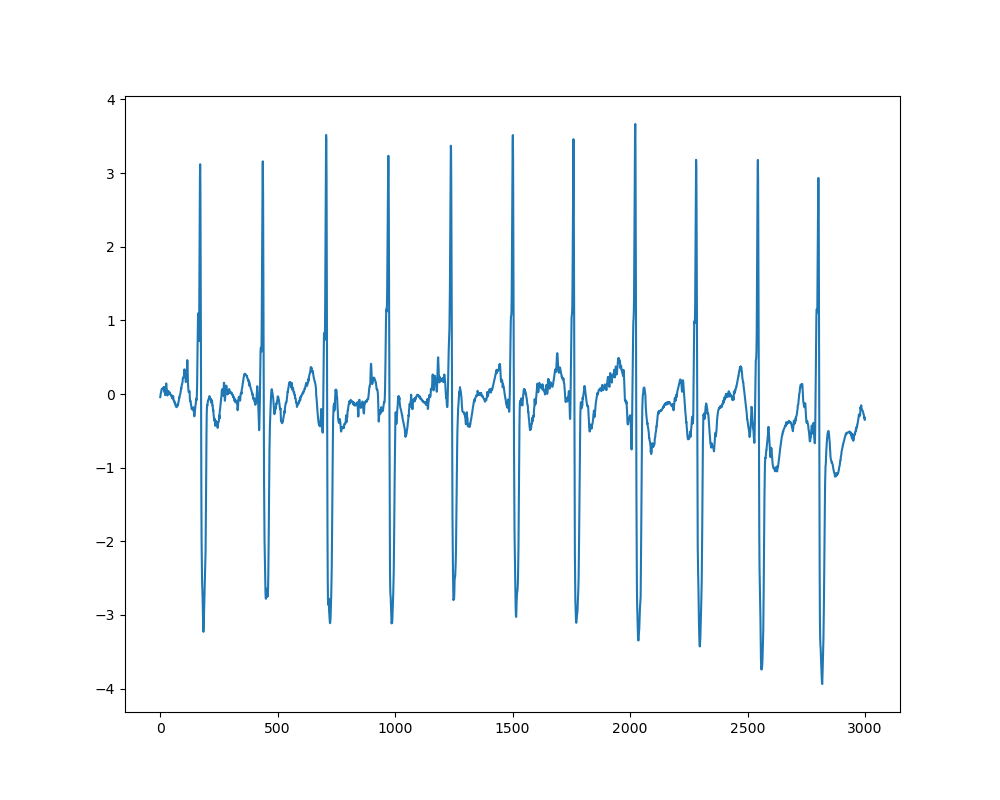

In [7]:
plt.figure(figsize=(10,8))
plt.plot(X[30100])
print(y[30100])

In [204]:
count_classes

[75052, 8075, 7259, 2546, 7130]

In [8]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(99598, 3001)


In [ ]:
k_max =  nk.complexity_k(X[7], k_max='default', show=True)

hfd = nk.fractal_higuchi(X[7], k_max=k_max, show=True)


In [ ]:
k_max, info =  nk.complexity_k(X[7], k_max='default', show=True)

hfd, info = nk.fractal_higuchi(X[7], k_max=k_max, show=True)


0.0    74691
1.0     8044
2.0     7226
4.0     7106
3.0     2531
Name: 3000, dtype: int64


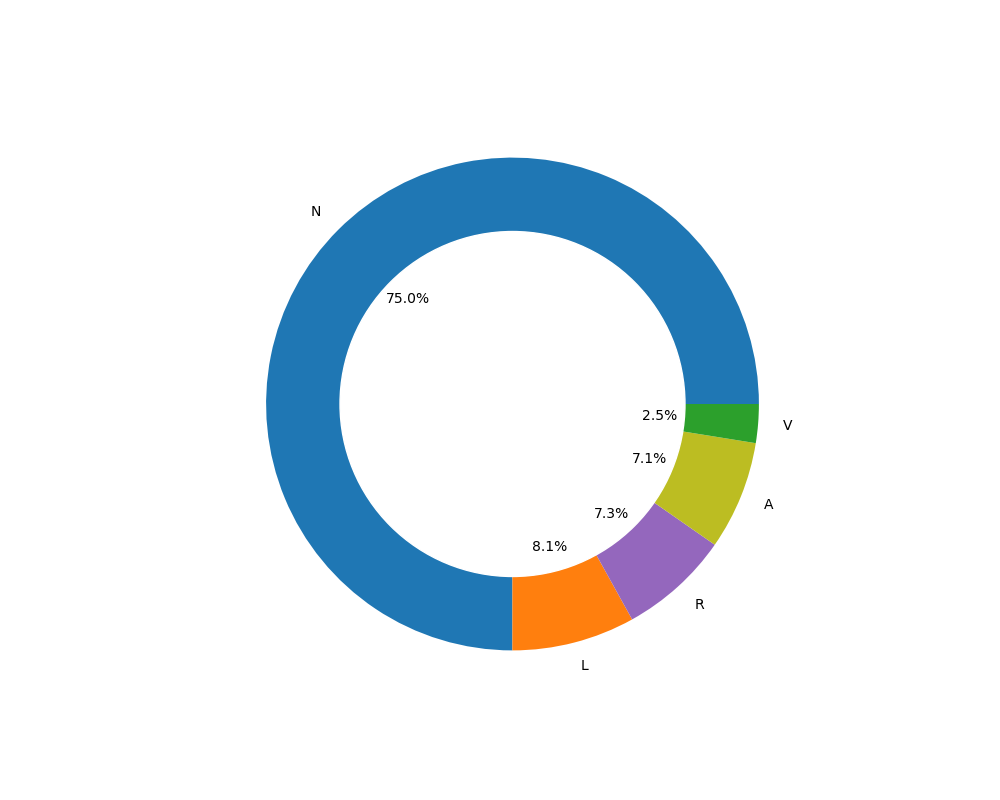

In [9]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(10,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Rebalancing Classes

In [10]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 3000, dtype: int64


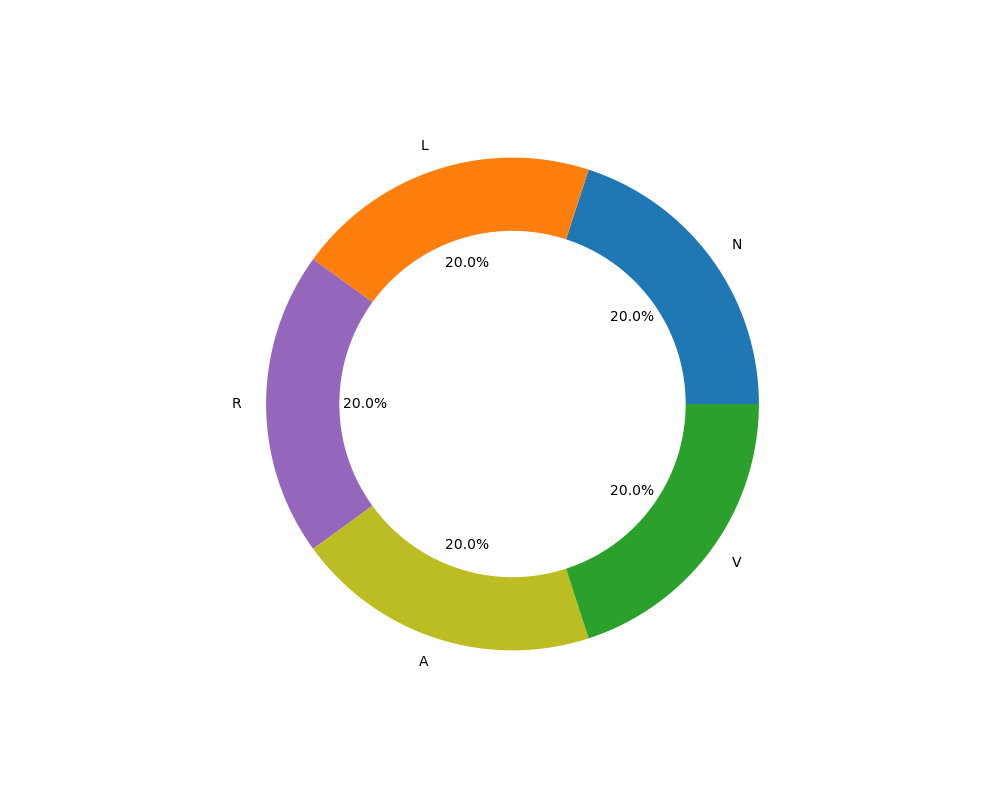

In [11]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(10,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


In [16]:
per_class

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 320, dtype: int64

In [12]:
X_train_df

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
22126,-2.768444,-3.021225,-2.955010,-2.603408,-2.115747,-1.600639,-1.090341,-1.025793,-1.112268,-0.997145,...,-0.645040,-0.626985,-0.644265,-0.670651,-0.689355,-0.706322,-0.725758,-0.734891,-0.756811,0.0
38470,-0.564422,-0.567615,-0.571931,-0.567176,-0.590598,-0.573927,-0.578495,-0.582000,-0.580238,-0.582344,...,-0.199484,-0.200340,-0.199977,-0.189646,-0.160244,-0.192877,-0.122287,-0.100418,-0.074131,0.0
96618,1.233149,1.257832,1.288298,1.322081,1.357829,1.388677,1.418498,1.448173,1.477684,1.511092,...,1.343714,1.735766,2.086565,2.407096,2.712574,2.976138,3.174546,3.297896,3.345934,0.0
84916,-0.012108,-0.039960,-0.065594,-0.091414,-0.120719,-0.148294,-0.175359,-0.197918,-0.200290,-0.190353,...,0.235121,0.294854,0.375561,0.485694,0.619198,0.760678,0.929128,1.105899,1.317779,0.0
83785,-0.731848,-0.720235,-0.712009,-0.693354,-0.671810,-0.651079,-0.630219,-0.611054,-0.592159,-0.573821,...,-0.083002,-0.080380,-0.077829,-0.074835,-0.069511,-0.062991,-0.056422,-0.049344,-0.041148,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33517,-0.383184,-0.396662,-0.422592,-0.452854,-0.481790,-0.466654,-0.435129,-0.414538,-0.398357,-0.366149,...,0.464706,0.453987,0.442150,0.432928,0.410099,0.408868,0.395116,0.377637,0.393155,4.0
33417,-0.287158,-0.313675,-0.340396,-0.363332,-0.386929,-0.407415,-0.423069,-0.447079,-0.467088,-0.451583,...,-2.214343,-2.148774,-2.082078,-2.006383,-1.951240,-1.853373,-1.776512,-1.679994,-1.591859,4.0
56982,0.341706,0.373176,0.404813,0.437799,0.471077,0.502586,0.533165,0.564706,0.594631,0.624235,...,-0.331319,-0.364625,-0.370835,-0.350501,-0.303560,-0.212882,-0.090983,0.094947,0.390112,4.0
86044,-0.446650,-0.489628,-0.498701,-0.453645,-0.199087,0.141564,0.501914,0.868248,1.167229,1.407205,...,-0.140025,0.141853,0.479661,0.847708,1.214439,1.484763,1.685403,1.861108,1.960088,4.0


In [13]:
beatdata = X_train_df.to_numpy()

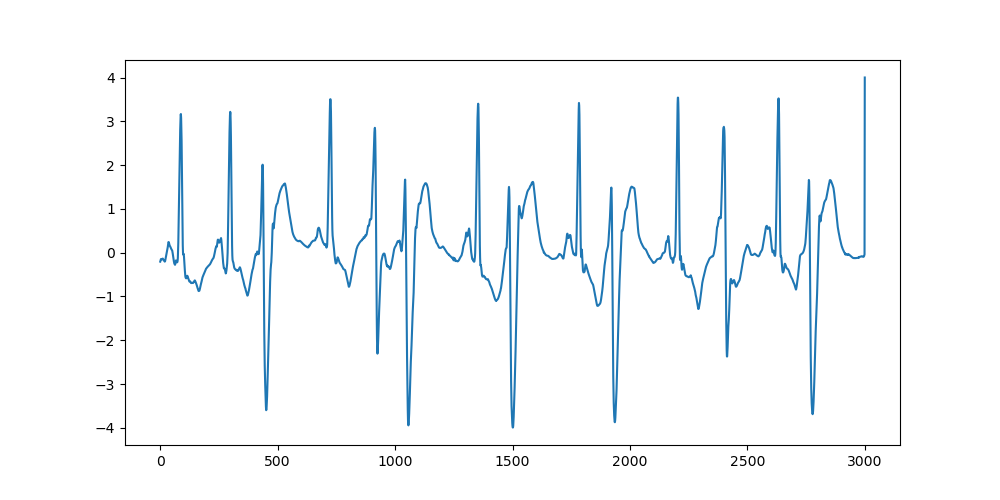

In [22]:
fig = plt.figure(figsize=(10,5))
plt.plot(beatdata[23000])

#k_max, info =  nk.complexity_k(beatdata[100], k_max='default', show=True)
#hfd, info = nk.fractal_higuchi(beatdata[100], k_max=k_max, show=True)

#h, info = nk.fractal_hurst(beatdata[23000], corrected=True, show=True)
#h

Feature Extraction

In [40]:
import nolds

h = nolds.dfa(beatdata[15000])
h


1.209528388842855

In [ ]:
dfa0 = np.zeros(1000)
h0 = np.zeros(1000)
cd0 = np.zeros(1000)
#lle0 = np.zeros(100)

for i in range(0,1000):
   
    dfa = nolds.dfa(beatdata[1000+i])
    h = nolds.hurst_rs(beatdata[1000+i])
    cd = nolds.corr_dim(beatdata[1000+i], 10)

    #lle, info = nk.complexity_lyapunov(beatdata[1000+i], method="rosenstein1993", show=False)


    dfa0[i] = dfa
    h0[i] = h
    cd0[i] = cd
    #lle0[i] = lle
    print(i)

In [77]:
dfa1 = np.zeros(1000)
h1 = np.zeros(1000)
cd1 = np.zeros(1000)
#lle0 = np.zeros(100)

for i in range(0,1000):
   
    dfa = nolds.dfa(beatdata[6000+i])
    h = nolds.hurst_rs(beatdata[6000+i])
    cd = nolds.corr_dim(beatdata[6000+i], 10)

    #lle, info = nk.complexity_lyapunov(beatdata[1000+i], method="rosenstein1993", show=False)


    dfa1[i] = dfa
    h1[i] = h
    cd1[i] = cd
    #lle0[i] = lle
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [78]:
dfa2 = np.zeros(1000)
h2 = np.zeros(1000)
cd2 = np.zeros(1000)
#lle0 = np.zeros(100)

for i in range(0,1000):
   
    dfa = nolds.dfa(beatdata[11000+i])
    h = nolds.hurst_rs(beatdata[11000+i])
    cd = nolds.corr_dim(beatdata[11000+i], 10)

    #lle, info = nk.complexity_lyapunov(beatdata[1000+i], method="rosenstein1993", show=False)


    dfa2[i] = dfa
    h2[i] = h
    cd2[i] = cd
    #lle0[i] = lle
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [79]:
dfa3 = np.zeros(1000)
h3 = np.zeros(1000)
cd3 = np.zeros(1000)
#lle0 = np.zeros(100)

for i in range(0,1000):
   
    dfa = nolds.dfa(beatdata[16000+i])
    h = nolds.hurst_rs(beatdata[16000+i])
    cd = nolds.corr_dim(beatdata[16000+i], 10)

    #lle, info = nk.complexity_lyapunov(beatdata[1000+i], method="rosenstein1993", show=False)


    dfa3[i] = dfa
    h3[i] = h
    cd3[i] = cd
    #lle0[i] = lle
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [80]:
dfa4 = np.zeros(1000)
h4 = np.zeros(1000)
cd4 = np.zeros(1000)
#lle0 = np.zeros(1000)

for i in range(0,1000):
   
    dfa = nolds.dfa(beatdata[21000+i])
    h = nolds.hurst_rs(beatdata[21000+i])
    cd = nolds.corr_dim(beatdata[21000+i], 10)

    #lle, info = nk.complexity_lyapunov(beatdata[1000+i], method="rosenstein1993", show=False)


    dfa4[i] = dfa
    h4[i] = h
    cd4[i] = cd
    #lle0[i] = lle
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


fdim0 = np.zeros(50)
h0 = np.zeros(50)
cd0 = np.zeros(50)
#lle0 = np.zeros(100)

for i in range(0,50):
    k_max, info =  nk.complexity_k(beatdata[1000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[1000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[1000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[1000+i], radius=32, show=False)

    #lle, info = nk.complexity_lyapunov(beatdata[1000+i], method="rosenstein1993", show=False)


    fdim0[i] = hfd
    h0[i] = h
    cd0[i] = cd
    #lle0[i] = lle
    print(i)

fdim1 = np.zeros(50)
h1 = np.zeros(50)
cd1 = np.zeros(50)
#lle1 = np.zeros(100)

for i in range(0,50):
    k_max, info =  nk.complexity_k(beatdata[6000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[6000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[6000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[6000+i], radius=32, show=False)

    #lle, info = nk.complexity_lyapunov(beatdata[6000+i], method="rosenstein1993", show=False)


    fdim1[i] = hfd
    h1[i] = h
    cd1[i] = cd
    #lle1[i] = lle
    print(i)

fdim2 = np.zeros(50)
h2 = np.zeros(50)
cd2 = np.zeros(50)
#lle2 = np.300(100)

for i in range(0,50):
    k_max, info =  nk.complexity_k(beatdata[11000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[11000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[11000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[11000+i], radius=32, show=False)

    #lle, info = nk.complexity_lyapunov(beatdata[11000+i], method="rosenstein1993", show=False)


    fdim2[i] = hfd
    h2[i] = h
    cd2[i] = cd
    #lle2[i] = lle
    print(i)

fdim3 = np.zeros(50)
h3 = np.zeros(50)
cd3 = np.zeros(50)
#lle3 = np.zeros(100)

for i in range(0,50):
    k_max, info =  nk.complexity_k(beatdata[16000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[16000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[16000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[16000+i], radius=32, show=False)

    #lle, info = nk.complexity_lyapunov(beatdata[16000+i], method="rosenstein1993", show=False)


    fdim3[i] = hfd
    h3[i] = h
    cd3[i] = cd
    #lle3[i] = lle
    print(i)


#plt.plot(beatdata[21000])

fdim4 = np.zeros(50)
h4 = np.zeros(50)
cd4 = np.zeros(50)
#lle4 = np.zeros(100)

for i in range(0,50):
    k_max, info =  nk.complexity_k(beatdata[22000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[22000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[22000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[22000+i], radius=32, show=False)

    #lle, info = nk.complexity_lyapunov(beatdata[22000+i], method="rosenstein1993", show=False)

    
    fdim4[i] = hfd
    h4[i] = h
    cd4[i] = cd
    #lle4[i] = lle
    print(i)



NameError: name 'fdim0' is not defined

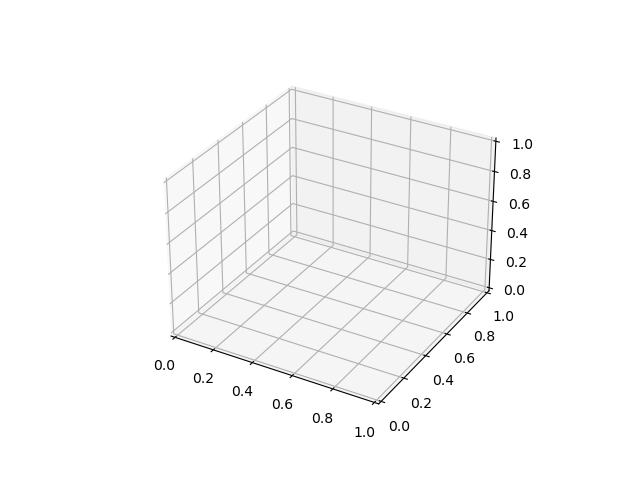

In [81]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(fdim0, h0, cd0)
#ax.scatter(fdim1, h1, cd1)
ax.scatter(fdim2, h2, cd2)
#ax.scatter(fdim3, h3, cd3)
#ax.scatter(fdim4, h4, cd4)

ax.set_xlabel('Higuchi Fractal Dimension')
ax.set_ylabel('Hurst Exponent')
ax.set_zlabel('Correlation dimension')
#ax.set_title("Higuchi fractal dimension vs Hurst exponent vs Correlation Dimension for 2 arrythmias")
ax.set_title("Higuchi fractal dimension vs Hurst exponent vs Correlation Dimension for 2 arrythmias and NSR")

plt.show()



In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Ndim = np.insert(np.stack((dfa0, h0, cd0), axis = 1),0,0, axis=1)    #0
Ldim = np.insert(np.stack((dfa1, h1, cd1), axis = 1),0,1, axis=1)     #1
Rdim = np.insert(np.stack((dfa2, h2, cd2), axis = 1),0,2, axis=1)    #2
Adim = np.insert(np.stack((dfa3, h3, cd3), axis = 1),0,3, axis=1)    #3
#Vdim = np.insert(np.stack((dfa4, h4, cd4), axis = 1),0,4, axis=1)    #4

labels  = np.array(np.concatenate((Ndim[:, 0], Ldim[:, 0], Rdim[:, 0], Adim[:, 0])), dtype=object)
Xfdim   = np.array(np.concatenate((Ndim[:, 1], Ldim[:, 1], Rdim[:, 1], Adim[:, 1])), dtype=object)
Xh      = np.array(np.concatenate((Ndim[:, 2], Ldim[:, 2], Rdim[:, 2], Adim[:, 2])), dtype=object)
Xcd     = np.array(np.concatenate((Ndim[:, 3], Ldim[:, 3], Rdim[:, 3], Adim[:, 3])), dtype=object)
#Xlle    = np.array(np.concatenate((Ndim[:, 4], Ldim[:, 4], Rdim[:, 4], Adim[:, 4], Vdim[:, 4])), dtype=object)


#Ndim[:, 4], Ldim[:, 4],  Rdim[:, 4], Adim[:, 4], Vdim[:, 4]


X = np.stack((labels, Xfdim, Xh, Xcd), axis =1)




names = ['Type', 'DFA', "Hurst", 'CD']
labels_df = X[:, 0]

df = pd.DataFrame(X, columns = names)

standardized_data = StandardScaler().fit_transform(df)
data_500 = standardized_data



pca = PCA(n_components=3)
#Npca = pca.fit_transform(Ndim)
#Lpca = pca.fit_transform(Ldim)
#Rpca = pca.fit_transform(Rdim)
#Apca = pca.fit_transform(Adim)
#Vpca = pca.fit_transform(Vdim)


df

,Type,DFA,Hurst,CD
0,0.0,1.387587,0.855776,1.307536
1,0.0,1.494611,0.870421,1.671824
2,0.0,1.464345,0.838501,1.716922
3,0.0,1.531455,0.889673,1.784308
4,0.0,1.495618,0.889998,1.739637
...,...,...,...,...
3995,3.0,1.424124,0.931807,2.159705
3996,3.0,1.380831,0.946738,2.426932
3997,3.0,1.43347,0.908578,2.133337
3998,3.0,1.407099,0.997429,1.765201


In [83]:
import pickle
import pandas as pd
df.to_pickle('FractalFeaturesDF4000_Window = 1500.pkl')
df

,Type,DFA,Hurst,CD
0,0.0,1.387587,0.855776,1.307536
1,0.0,1.494611,0.870421,1.671824
2,0.0,1.464345,0.838501,1.716922
3,0.0,1.531455,0.889673,1.784308
4,0.0,1.495618,0.889998,1.739637
...,...,...,...,...
3995,3.0,1.424124,0.931807,2.159705
3996,3.0,1.380831,0.946738,2.426932
3997,3.0,1.43347,0.908578,2.133337
3998,3.0,1.407099,0.997429,1.765201


Histograms of Data

ValueError: Could not interpret value `FD` for parameter `x`

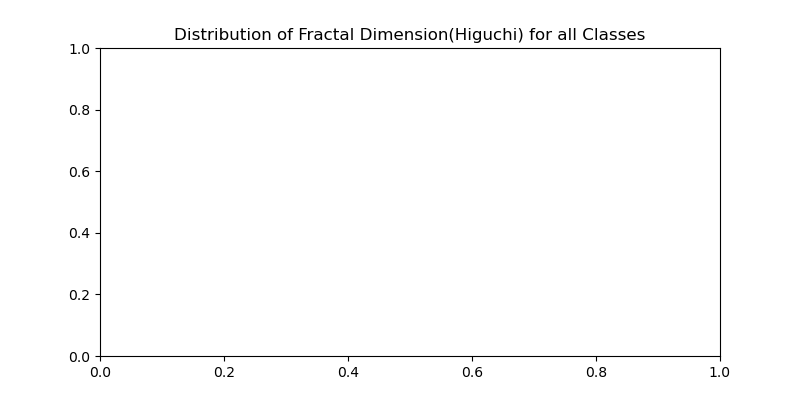

In [84]:
import seaborn as sn
import matplotlib.colors as colors



#g = sn.FacetGrid(data=df, col='T', col_wrap=3, height=3, aspect=1)
#g.map(sn.histplot, 'CD', bins = 10, color = 'blue', kde=True)
#g.map(sn.histplot, 'Hurst', bins = 10, color = 'red', kde=True)
#g.map(sn.histplot, 'FD', bins = 10, color = 'green', kde=True)

#print("Calculating the mean for each feature:")


fig = plt.figure(figsize=(8,4))
plt.title("Distribution of Fractal Dimension(Higuchi) for all Classes")
sn.histplot(data=df, x='FD', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('Higuchi Fractal Dimension')
print(df.groupby("Type")['FD'].mean())

fig = plt.figure(figsize=(8,4))
plt.title("Distribution of Correlation Dimension for all Classes")
sn.histplot(data=df, x='CD', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('Correlation Dimension')
print(df.groupby("Type")["CD"].mean())

fig = plt.figure(figsize=(8,4))
plt.title("Distribution of Hurst Exponent for all Classes")
sn.histplot(data=df, x='Hurst', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('Hurst Exponent')
print(df.groupby("Type")["Hurst"].mean())

#fig = plt.figure(figsize=(8,4))
#plt.title("Distribution of LLE for all Classes")
#sn.histplot(data=df, x='LLE', hue = 'Type', bins=20, kde=True, palette = 'tab10').set(xlim=(0,0.2))
#print('LLE')
#print(df.groupby("Type")["LLE"].mean())


#sn.histplot(data=fdim2, bins=30, kde=True)

#sn.histplot(data=fdim3, bins=30, kde=True)

#sn.histplot(data=fdim4, bins=30, kde=True)


<AxesSubplot:ylabel='Count'>

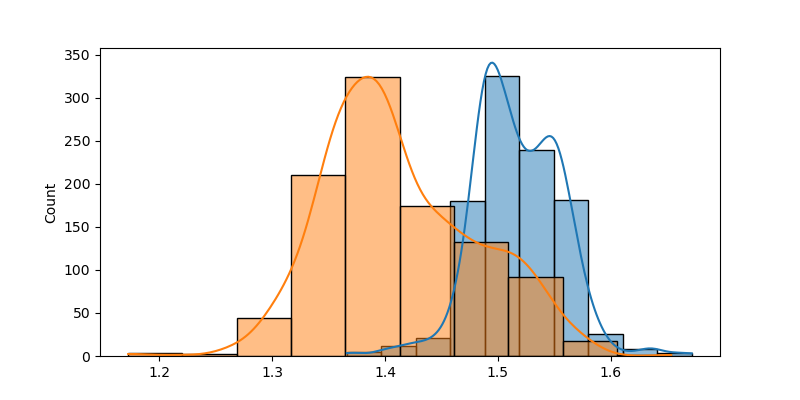

In [ ]:
fig = plt.figure(figsize=(8,4))

sn.histplot(data=fdim2, bins=10, kde=True, common_bins=True)

sn.histplot(data=fdim1, bins=10, kde=True, common_bins=True)

c:\Users\Matt Segue\anaconda3\envs\neurokit\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


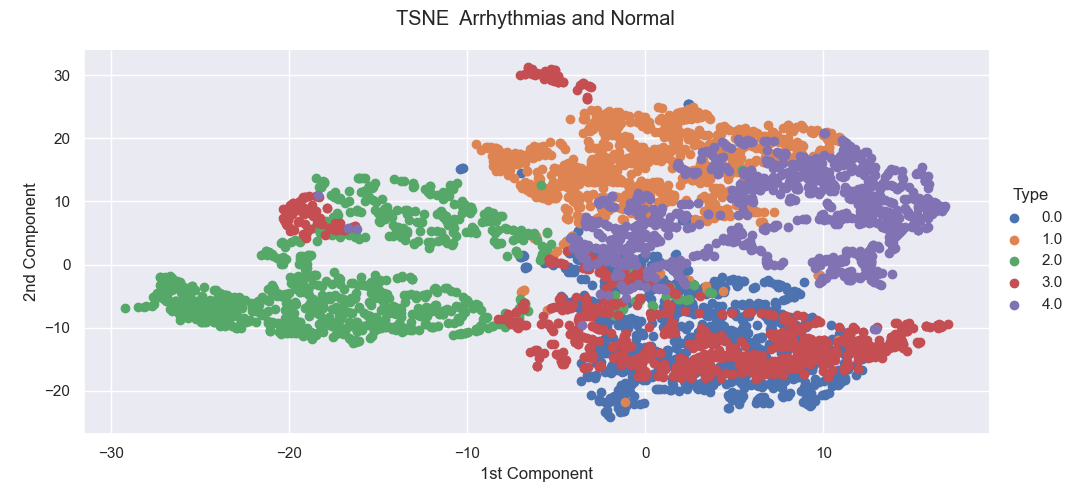

,1st Component,2nd Component,3rd Component,Type
0,10.30176,-15.097985,-5.816231,0.0
1,12.194001,-14.924112,-6.220805,0.0
2,-0.616746,-20.828295,-17.754686,0.0
3,-1.417561,-21.054707,-16.026384,0.0
4,10.417626,-9.627621,-9.830706,0.0
...,...,...,...,...
4995,11.894414,-1.924597,16.050125,4.0
4996,8.494724,14.069895,6.899613,4.0
4997,5.328523,11.845004,9.404881,4.0
4998,12.867017,15.179465,7.372506,4.0


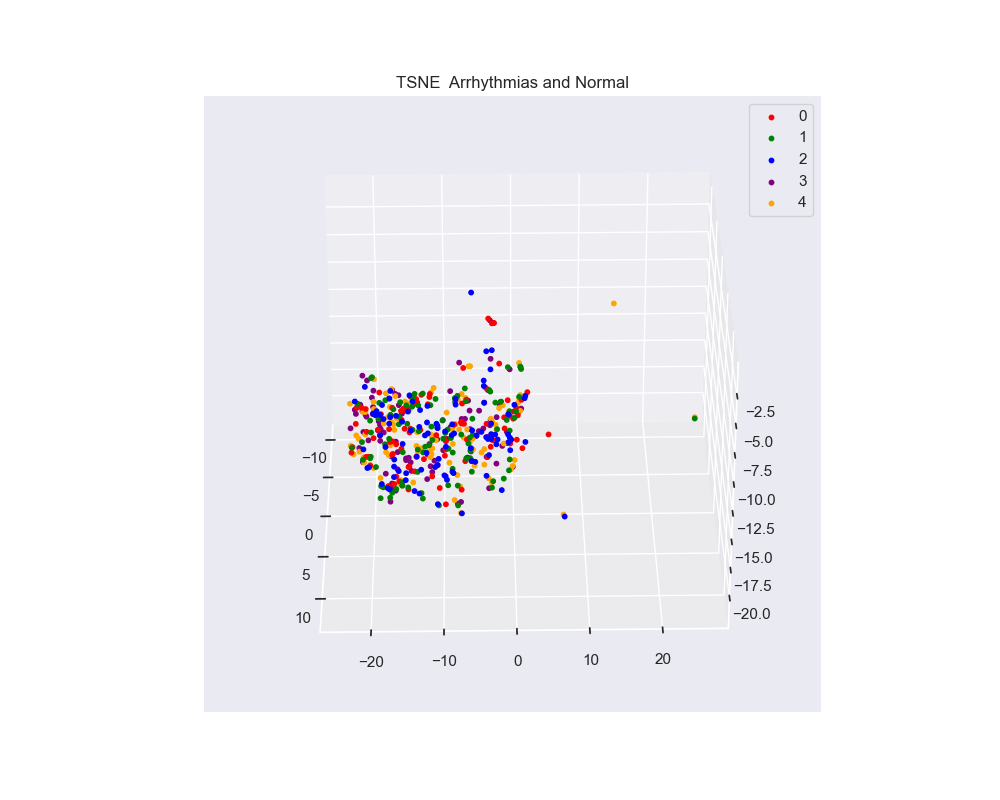

In [ ]:
from code import interact
from tkinter import Y
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import axes3d 



tsne = TSNE(n_components=3,  random_state=0, perplexity=20,early_exaggeration=6, n_iter=2000, learning_rate = 600, n_iter_without_progress=300, angle=0.5)
labels_500 = labels_df
Xtsne = tsne.fit_transform(data_500)

tsne_data = np.vstack((Xtsne.T, labels_500)).T


tsne_data

sn.set(style = "darkgrid")

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')


#3 Components
tsne_df = pd.DataFrame(tsne_data, columns = ('1st Component', '2nd Component', '3rd Component','Type'))

#2 Components
#tsne_df = pd.DataFrame(tsne_data, columns = ('1st Component', '2nd Component', '3rd Component','Type'))


sn.FacetGrid(tsne_df, hue = 'Type', aspect = 2, height = 5).map(plt.scatter, '1st Component', '2nd Component').add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle('TSNE  Arrhythmias and Normal ')

x = tsne_df["1st Component"].to_numpy()
y = tsne_df["2nd Component"].to_numpy()
z = tsne_df["3rd Component"].to_numpy()

#Plotting n=3 Components
ax.scatter(x[:100],    y[:100],    z[:100],    s=10,   c = 'red', cmap=plt.cm.prism, label = 0, alpha = 1)          #0
ax.scatter(x[100:200], y[100:200], z[100:200], s = 10, c = 'green', cmap=plt.cm.prism, label = 1, alpha = 1)        #1
ax.scatter(x[200:300], y[200:300], z[200:300], s = 10, c = 'blue', cmap=plt.cm.prism, label = 2, alpha = 1)         #2
ax.scatter(x[300:400], y[300:400], z[300:400], s = 10, c = 'purple', cmap=plt.cm.prism, label = 3, alpha = 1)       #3
ax.scatter(x[400:500], y[400:500], z[400:500], s = 10, c = 'orange', cmap=plt.cm.prism, label = 4, alpha = 1)       #4


#Plotting n=2 Components
#ax.scatter(x[:200],y[:200], s=10, c = 'red', cmap=plt.cm.prism, label = 0, alpha = 1)                   #0
#ax.scatter(x[200:400], y[200:400], s = 10, c = 'green', cmap=plt.cm.prism, label = 1, alpha = 1)        #1
#ax.scatter(x[400:600], y[400:600], s = 10, c = 'blue', cmap=plt.cm.prism, label = 2, alpha = 1)         #2
#ax.scatter(x[600:800],y[600:800], s = 10, c = 'purple', cmap=plt.cm.prism, label = 3, alpha = 1)        #3
#ax.scatter(x[800:1000],y[800:1000], s = 10, c = 'orange', cmap=plt.cm.prism, label = 4, alpha = 1)      #4

#z[:100]

ax.legend()
ax.set_title('TSNE  Arrhythmias and Normal')



for angle in range(0, 360):
   ax.view_init(30, angle)
  


plt.show()

tsne_df



In [ ]:
X_train_df

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
59186,-0.254715,-0.270753,-0.167196,-0.021486,0.009363,-0.010336,0.010390,-0.014690,0.066862,-0.121582,...,-0.061446,-0.031643,-0.071650,-0.075833,-0.082121,-0.091430,-0.095677,-0.102803,-0.109033,0.0
58629,0.575804,0.568762,0.559688,0.542016,0.520491,0.495039,0.465671,0.446313,0.413036,0.389862,...,0.029008,0.050094,0.092615,0.045616,-0.008566,-0.014315,0.004940,0.040263,0.037002,0.0
83563,-0.413186,-0.345284,-0.244411,-0.171639,-0.038484,0.098163,0.251617,0.395660,0.423763,0.421312,...,-0.668138,-0.735290,-0.835996,-0.939371,-1.049496,-1.163195,-1.273324,-1.369526,-1.454217,0.0
25693,-0.477686,-0.462402,-0.447063,-0.426353,-0.403748,-0.384641,-0.366544,-0.344644,-0.324860,-0.304241,...,-1.193618,-1.217063,-1.240018,-1.262189,-1.282598,-1.301719,-1.320388,-1.338075,-1.353749,0.0
32034,-0.135638,-0.133801,-0.133726,-0.139770,-0.142445,-0.145179,-0.148998,-0.152765,-0.154845,-0.155763,...,-0.200898,-0.196186,-0.186350,-0.218096,-0.196825,-0.202887,-0.203406,-0.218122,-0.216660,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62577,-0.396738,-0.407132,-0.408455,-0.409901,-0.412390,-0.418704,-0.412212,-0.403680,-0.443922,-0.401792,...,-0.085602,-0.086959,-0.094638,-0.071717,-0.089133,-0.086605,-0.090831,-0.075716,-0.095683,4.0
43813,-0.015512,0.023468,0.049631,0.078294,0.077537,0.069895,0.097026,0.129967,0.159551,0.148816,...,0.119975,0.150738,0.131687,0.139335,0.145054,0.148850,0.151485,0.154639,0.157573,4.0
55929,0.809013,1.064941,1.403971,1.725946,2.090258,2.586043,3.128772,3.768961,4.343389,4.714972,...,-0.386575,-0.383577,-0.380396,-0.377161,-0.374135,-0.371177,-0.368006,-0.364950,-0.361813,4.0
79933,-0.180190,-0.193850,-0.206816,-0.255565,-0.291154,-0.378596,-0.336949,-0.330031,-0.354611,-0.365400,...,0.126741,0.133249,0.138305,0.137296,0.161618,0.164197,0.144573,0.166394,0.184694,4.0


In [ ]:
cnames = []
for i in range(320):
    cnames.append(str(i))

cnames.append('Type')

In [ ]:
X_train_df.columns =  cnames


In [ ]:
ndf = X_train_df.iloc[1000:1100]
ldf =X_train_df.iloc[6000:6100]
rdf =X_train_df.iloc[11000:11100]
adf =X_train_df.iloc[16000:16100]
vdf =X_train_df.iloc[21000:21100]

In [ ]:
X_train_df = pd.concat([ndf, ldf,rdf,adf,vdf], axis=0)



,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,Type
38569,-0.565689,-0.562230,-0.576413,-0.566832,-0.570158,-0.568978,-0.574525,-0.596271,-0.535517,-0.584819,...,-0.411464,-0.512375,-0.449620,-0.469481,-0.481085,-0.485242,-0.484490,-0.488543,-0.490307,0.0
89036,-0.009627,0.019927,0.011808,0.006995,-0.004015,-0.004389,-0.002805,-0.000694,0.001955,-0.002693,...,-0.095657,-0.097803,-0.099575,-0.102076,-0.098734,-0.094071,-0.105887,-0.120758,-0.123630,0.0
80835,-0.073540,-0.083369,-0.122314,-0.180982,-0.135285,-0.082872,-0.079523,-0.093932,-0.092853,-0.078660,...,-0.045578,-0.030756,-0.000383,-0.065098,-0.065980,-0.064640,-0.029307,-0.029857,-0.038359,0.0
81838,0.238102,0.231721,0.226631,0.218935,0.221753,0.236998,0.181958,0.195148,0.188075,0.188523,...,0.277326,0.278318,0.282023,0.265937,0.274472,0.297977,0.330483,0.275715,0.205464,0.0
46062,-0.260781,-0.254888,-0.245899,-0.255723,-0.289446,-0.299669,-0.301498,-0.251733,-0.188839,-0.218990,...,-0.273133,-0.242982,-0.226359,-0.204922,-0.216730,-0.229980,-0.223610,-0.214068,-0.165040,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10372,-0.792106,-0.777642,-0.768670,-0.766626,-0.760206,-0.770997,-0.772707,-0.774547,-0.779188,-0.783616,...,-0.655933,-0.655573,-0.653778,-0.653376,-0.661146,-0.624426,-0.624922,-0.649396,-0.687481,4.0
10864,-1.995704,-1.794733,-1.575652,-1.403130,-1.246323,-1.098332,-0.964278,-0.817890,-0.681894,-0.601972,...,-0.661351,-0.659450,-0.662317,-0.666910,-0.669347,-0.671591,-0.675098,-0.679170,-0.683113,4.0
53701,-0.414362,-0.405740,-0.396012,-0.384454,-0.380641,-0.366197,-0.357239,-0.347621,-0.336869,-0.325673,...,-0.276098,-0.290916,-0.302575,-0.312462,-0.319626,-0.330997,-0.335273,-0.339825,-0.345406,4.0
32559,-0.184667,-0.185924,-0.196680,-0.221521,-0.241324,-0.247511,-0.259260,-0.304378,-0.305877,-0.319869,...,-0.651116,-0.647175,-0.651772,-0.659552,-0.666068,-0.672049,-0.682239,-0.696726,-0.689801,4.0


SVM with on raw data (Limited Dataset)

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
X = X_train_df.drop(['Type'], axis=1)
y = X_train_df['Type'].astype('int')

In [ ]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((400, 320), (100, 320))

In [ ]:
cols = X_train.columns

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [ ]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,...,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,1.332268e-17,1.443290e-17,-1.110223e-17,1.110223e-17,-6.661338e-18,-8.881784e-18,4.440892e-18,4.440892e-18,-6.661338e-18,6.661338e-18,...,-2.220446e-17,-2.220446e-17,-8.881784e-18,0.000000,-4.440892e-18,3.330669e-17,6.661338e-18,3.552714e-17,-6.661338e-18,-8.881784e-18
std,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,...,1.001252e+00,1.001252e+00,1.001252e+00,1.001252,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00
min,-3.009247e+00,-2.969521e+00,-2.879571e+00,-2.707486e+00,-2.646344e+00,-2.636075e+00,-2.631491e+00,-2.619428e+00,-2.546354e+00,-2.477249e+00,...,-4.432660e+00,-4.387292e+00,-4.364720e+00,-4.471088,-4.697460e+00,-4.966470e+00,-5.094400e+00,-4.976835e+00,-4.688943e+00,-4.414753e+00
25%,-4.999234e-01,-5.196819e-01,-5.310237e-01,-5.190943e-01,-5.027788e-01,-5.028539e-01,-5.011426e-01,-5.007705e-01,-4.975767e-01,-4.923505e-01,...,-4.434989e-01,-4.380566e-01,-4.357501e-01,-0.447847,-4.856976e-01,-5.059334e-01,-4.982538e-01,-4.866176e-01,-4.575803e-01,-4.574065e-01
50%,-1.866571e-01,-1.944335e-01,-1.835191e-01,-1.928160e-01,-1.862992e-01,-1.866415e-01,-1.911895e-01,-1.710982e-01,-1.718630e-01,-1.626297e-01,...,-3.844381e-02,-3.839520e-02,-4.618662e-02,-0.042040,-3.942112e-02,-3.200855e-02,-2.516844e-02,-1.649923e-02,-1.683568e-02,-1.444740e-02
75%,2.448846e-01,2.589778e-01,2.619231e-01,2.391376e-01,2.351745e-01,2.422064e-01,2.332518e-01,2.495471e-01,2.379005e-01,2.397860e-01,...,3.782216e-01,3.596256e-01,3.432211e-01,0.335066,3.521630e-01,3.797998e-01,4.032069e-01,4.087712e-01,3.911350e-01,3.973191e-01
max,6.360706e+00,6.517047e+00,6.534530e+00,6.407771e+00,6.215917e+00,6.261175e+00,6.601621e+00,6.922226e+00,7.207972e+00,7.566179e+00,...,7.908204e+00,9.231301e+00,9.748965e+00,9.327316,7.685041e+00,7.201804e+00,6.296477e+00,7.091003e+00,7.731819e+00,8.332084e+00


In [ ]:
# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


#rbf svc
svc=SVC(C=50.0) 

#polynomial svc
#poly_svc=SVC(kernel='poly', C=4000) 

#sigmoid svc
#sigmoid_svc=SVC(kernel='sigmoid', C=1000.0)

# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=1000.0 : 0.9000


Declare feature vector and target variable

In [85]:
X = df.drop(['Type'], axis=1)
#X = X.drop(['LLE'], axis =1)
y = df['Type'].astype('int')


Split data into separate training and test set 


In [86]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [87]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((3200, 3), (800, 3))

Feature Scaling

In [88]:
cols = X_train.columns

In [89]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [91]:
X_train = pd.DataFrame(X_train, columns=[cols])


In [90]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [92]:
X_train.describe()

,DFA,Hurst,CD
count,3.200000e+03,3.200000e+03,3.200000e+03
mean,1.252443e-14,3.183342e-14,1.156852e-15
std,1.000156e+00,1.000156e+00,1.000156e+00
min,-3.696270e+00,-3.851192e+00,-2.025521e+00
25%,-5.567099e-01,-7.859072e-01,-7.554224e-01
50%,-8.506206e-02,1.381301e-01,-3.010391e-01
75%,7.328875e-01,7.829583e-01,6.327141e-01
max,2.617266e+00,3.025551e+00,3.504346e+00


Run SVM  


In [110]:
# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


#rbf svc
svc=SVC(C=10000.0) 

#polynomial svc
#poly_svc=SVC(kernel='poly', C=4000) 

#sigmoid svc
#sigmoid_svc=SVC(kernel='sigmoid', C=1000.0)

# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=160.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=160.0 : 0.7575


Compare the train-set and test-set accuracy

In [111]:
y_pred_train = svc.predict(X_train)



In [112]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8131


Check for overfitting and underfitting

In [109]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(svc.score(X_test, y_test)))

Training set score: 0.7847
Test set score: 0.7625


In [99]:
# check class distribution in test set

y_test.value_counts()

0    219
3    203
2    190
1    188
Name: Type, dtype: int64

In [100]:
# check null accuracy score

null_accuracy = (25/(100))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.2500


Confusion matrix 

In [101]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

#print('Confusion matrix\n\n', cm)

#print('\nTrue Positives(TP) = ', cm[0,0])

#print('\nTrue Negatives(TN) = ', cm[1,1])

#print('\nFalse Positives(FP) = ', cm[0,1])

#print('\nFalse Negatives(FN) = ', cm[1,0])

Text(0.5, 1.0, 'Confusion Matrix')

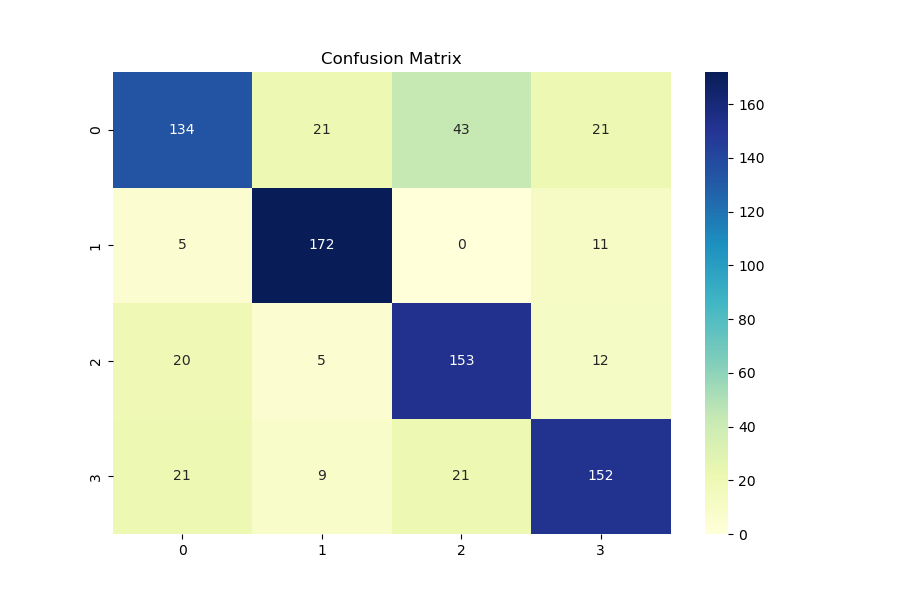

In [103]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['0', '1', '2', '3'], 
                                 index=['0', '1', '2', '3'])

f, ax = plt.subplots(figsize=(9, 6))
g = sn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
ax.set_title('Confusion Matrix')
